## V2

                   Strategy    Benchmark
ann_return_geo     0.313958     0.150693
ann_vol            0.256430     0.178572
sharpe             1.192642     0.875941
max_dd            -0.276562    -0.296722
n_obs           2906.000000  2906.000000
Date
2014   -0.038503
2015    1.433575
2016   -0.060973
2017    0.047902
2018    0.030908
2019    0.509697
2020    0.241856
2021   -0.005327
2022    0.128679
2023    0.180960
2024    0.800169
2025    1.053560
2026    0.068493
dtype: float64


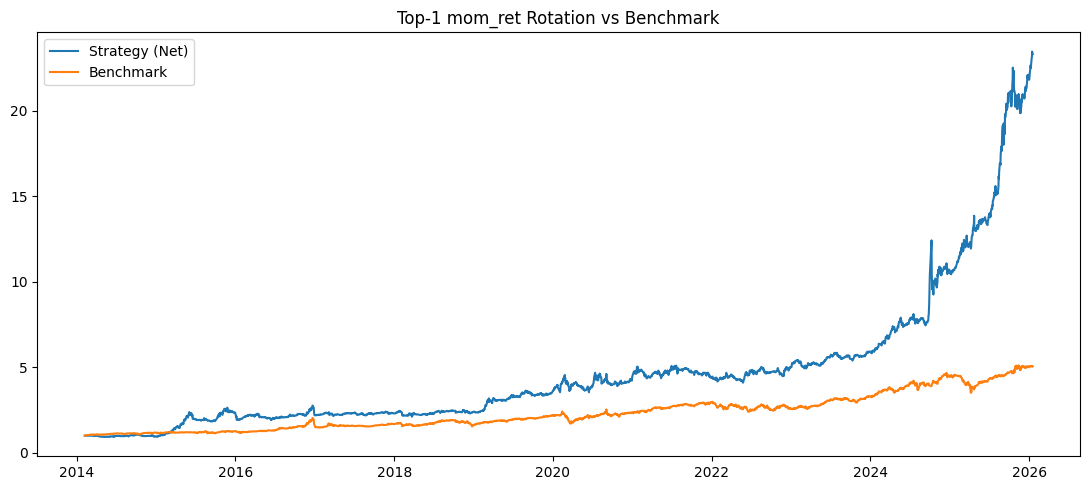

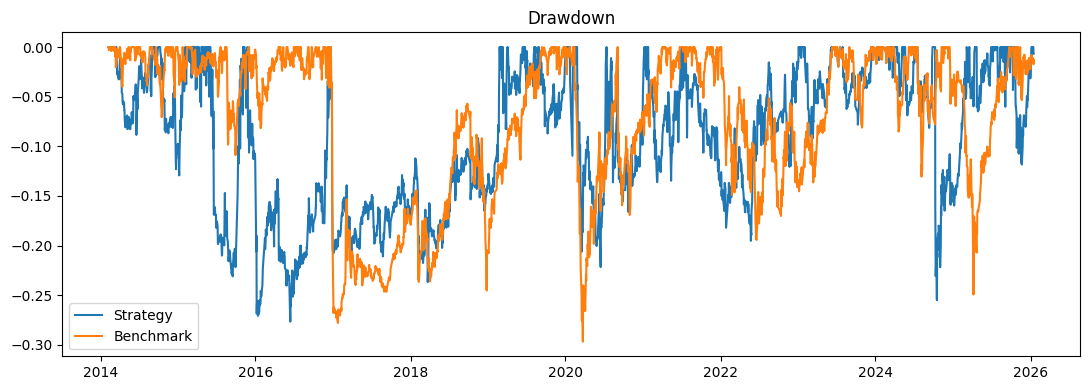

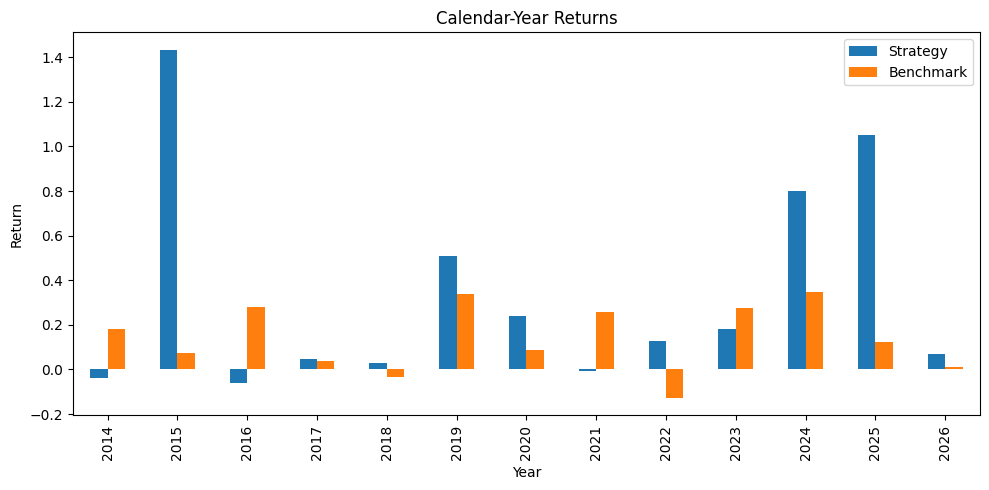

In [64]:
"""
Top-K Momentum Rotation vs Benchmark (Experiment)
-------------------------------------------------
This is a THIN orchestration script that uses qresearch library modules.

"""

from __future__ import annotations

from dataclasses import dataclass, replace, field
from typing import List, Literal, Optional, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== library imports (your refactored code) =====
import qresearch.signals as qsigs
from qresearch.data.yfinance import *
from qresearch.backtest.portfolio import *
from qresearch.backtest.metrics import *
from qresearch.portfolio.weights import *

RebalanceMode = Literal["calendar", "fixed_h"]


@dataclass(frozen=True)
class ExperimentConfig:
    start: str = "2014-02-07"
    end: Optional[str] = None
    
    # schedule
    rebalance_mode: RebalanceMode = "fixed_h"
    rebalance: str = "W-FRI"     # used if calendar
    H: int = 5                   # used if fixed_h
    offset: int = 0

    top_k: int = 1
    fee_bps: float = 2.0

    benchmark_mode: Literal["equal_weight_all", "single_ticker"] = "single_ticker"
    benchmark_ticker: Optional[str] = None
    rf_annual: float = 0.0

    # registry-style
    signal_name: str = "mom_ret"
    signal_params: Dict[str, Any] = field(default_factory=lambda: {"lookback": 21, "skip": 0})


def build_benchmark_weights(prices: pd.DataFrame, cfg: ExperimentConfig) -> pd.DataFrame:
    cols = prices.columns.tolist()

    if cfg.benchmark_mode == "equal_weight_all":
        w = pd.Series(1.0 / len(cols), index=cols)
        return pd.DataFrame(np.tile(w.values, (len(prices), 1)), index=prices.index, columns=cols)

    if cfg.benchmark_mode == "single_ticker":
        if not cfg.benchmark_ticker or cfg.benchmark_ticker not in cols:
            raise ValueError("benchmark_ticker must be in prices.columns")
        w = pd.Series(0.0, index=cols)
        w[cfg.benchmark_ticker] = 1.0
        return pd.DataFrame(np.tile(w.values, (len(prices), 1)), index=prices.index, columns=cols)

    raise ValueError(f"Unknown benchmark_mode: {cfg.benchmark_mode}")


def plot_compare(eq_s: pd.Series, eq_b: pd.Series, ret_s: pd.Series, ret_b: pd.Series, title: str) -> None:
    # equity
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(eq_s.index, eq_s.values, label="Strategy (Net)")
    ax.plot(eq_b.index, eq_b.values, label="Benchmark")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    plt.show()

    # drawdown
    dd_s = drawdown_series_from_equity(eq_s)
    dd_b = drawdown_series_from_equity(eq_b)
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.plot(dd_s.index, dd_s.values, label="Strategy")
    ax.plot(dd_b.index, dd_b.values, label="Benchmark")
    ax.set_title("Drawdown")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # yearly returns
    yr_s = yearly_returns(ret_s).rename("Strategy")
    yr_b = yearly_returns(ret_b).rename("Benchmark")
    yr_tbl = pd.concat([yr_s, yr_b], axis=1).sort_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    yr_tbl.plot(kind="bar", ax=ax)
    ax.set_title("Calendar-Year Returns")
    ax.set_ylabel("Return")
    ax.set_xlabel("Year")
    fig.tight_layout()
    plt.show()


def run_one(md: MarketData, cfg: ExperimentConfig) -> dict:
    # 1) signal scores (library)
    scores = qsigs.compute_signal(md, cfg.signal_name, **cfg.signal_params)

    # 2) weights (library)
    wcfg = TopKConfig(
        mode=cfg.rebalance_mode,    # "calendar" or "fixed_h"
        rebalance=cfg.rebalance,    # used only when mode="calendar"
        H=cfg.H,                    # used only when mode="fixed_h"
        offset=cfg.offset,          # used only when mode="fixed_h"
        top_k=cfg.top_k,
        use_absolute_filter=False,
    )
    w_strat = build_topk_weights(prices=md.close, scores=scores, cfg=wcfg)

    # 3) backtest (library engine)
    strat = backtest_weights(
        prices=md.close,
        weights=w_strat,         # unshifted decision-time weights
        fee_bps=cfg.fee_bps,
        rf_annual=cfg.rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # 4) benchmark weights + backtest
    w_bench = build_benchmark_weights(md.close, cfg)
    bench = backtest_weights(
        prices=md.close,
        weights=w_bench,
        fee_bps=0.0,
        rf_annual=cfg.rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # 5) standardized stats (use returns, not equity-only)
    stats_s = pd.Series(perf_summary(strat.net_ret, freq=TRADING_DAYS), name="Strategy")
    stats_b = pd.Series(perf_summary(bench.net_ret, freq=TRADING_DAYS), name="Benchmark")

    return {
        "cfg": cfg,
        "scores": scores,
        "weights_strategy": w_strat,
        "weights_benchmark": w_bench,
        "strat": strat,
        "bench": bench,
        "stats": pd.concat([stats_s, stats_b], axis=1),
    }

def _compound(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return float((1.0 + r).prod() - 1.0)


assets = {
    'ChiNext': '159915.SZ',
    'SP500': '513500.SS',
    'HangSeng': '159920.SZ',
    'Gold': '518880.SS'
}

tickers = list(assets.values())

cfg = ExperimentConfig(
    start="2014-02-07",
    H=5,
    top_k=1,
    fee_bps=2.0,
    rebalance_mode='calendar',
    rebalance='W-FRI',
    benchmark_mode="single_ticker",
    benchmark_ticker="513500.SS",
    signal_name="mom_ret",
    signal_params = {"lookback": 21},
)

market_data = download_market_data(tickers, start=cfg.start, end=cfg.end)

out = run_one(market_data, cfg)
print(out["stats"])
print(yearly_returns(out['strat'].net_ret))

plot_compare(
    eq_s=out["strat"].equity_net,
    eq_b=out["bench"].equity_net,
    ret_s=out["strat"].net_ret,
    ret_b=out["bench"].net_ret,
    title=f"Top-{cfg.top_k} {cfg.signal_name} Rotation vs Benchmark",
)


In [3]:
def build_weights_top1_switch_on_spread(
    prices: pd.DataFrame,
    scores: pd.DataFrame,
    rebalance: str = "W-FRI",
    spread_allow_q: float = 0.7,     # only allow switching when spread is >= this quantile
) -> pd.DataFrame:
    """
    Decision-time weights (unshifted) for Top-1 rotation with spread-gated switching.
    - At rebalance date t (close), decide weights for the next holding interval.
    - backtest_weights will apply weights.shift(1) to enforce no-lookahead.
    """
    scores = scores.reindex(prices.index)
    reb_scores = scores.resample(rebalance).last().dropna(how="all")

    def top1_top2_spread(row: pd.Series) -> float:
        s = row.replace([np.inf, -np.inf], np.nan).dropna()
        if len(s) < 2:
            return np.nan
        x = s.sort_values(ascending=False).iloc[:2].values
        return float(x[0] - x[1])

    spread = reb_scores.apply(top1_top2_spread, axis=1)
    thresh = float(spread.quantile(spread_allow_q))

    w_reb = pd.DataFrame(index=reb_scores.index, columns=prices.columns, dtype=float)
    prev = None

    for dt in reb_scores.index:
        s = reb_scores.loc[dt].replace([np.inf, -np.inf], np.nan).dropna()
        w = pd.Series(0.0, index=prices.columns)

        if len(s) == 0:
            w_reb.loc[dt] = w
            continue

        ranked = s.sort_values(ascending=False)
        leader = ranked.index[0]
        sp = spread.loc[dt]

        if prev is None:
            chosen = leader
        else:
            allow_switch = (np.isfinite(sp) and sp >= thresh)
            chosen = leader if allow_switch else prev

        w.loc[chosen] = 1.0
        w_reb.loc[dt] = w
        prev = chosen

    # Expand decision-time weights to daily by ffill
    weights = w_reb.reindex(prices.index).ffill().fillna(0.0)
    return weights

qs = [d / 10 for d in range(11)]
rows = []

for q in qs:
    w = build_weights_top1_switch_on_spread(market_data.close, out['scores'], cfg.rebalance, spread_allow_q=q)
    bt = backtest_weights(market_data.close, w, fee_bps=cfg.fee_bps, rf_annual=0.0)

    # use your own stats function if you have one; otherwise:
    stats = perf_summary(bt.net_ret, TRADING_DAYS)

    rows.append({
        "switch_allow_q": q,
        "Ann Return": stats["ann_return_geo"],
        "Ann Vol": stats["ann_vol"],
        "Sharpe": stats["sharpe"],
        "Max DD": stats["max_dd"],
        "Turnover_avg": float(bt.turnover.mean()),
    })

tbl = pd.DataFrame(rows).set_index("switch_allow_q")
print(tbl.to_string(float_format=lambda x: f"{x:0.4f}"))


                Ann Return  Ann Vol  Sharpe  Max DD  Turnover_avg
switch_allow_q                                                   
0.0                 0.3456   0.2514  1.3058 -0.2550        0.1270
0.1                 0.3052   0.2520  1.1823 -0.2550        0.1077
0.2                 0.2793   0.2529  1.0999 -0.2944        0.0933
0.3                 0.2389   0.2789  0.9074 -0.4989        0.0781
0.4                 0.2162   0.2791  0.8404 -0.4989        0.0671
0.5                 0.1591   0.2853  0.6598 -0.5563        0.0595
0.6                 0.1523   0.2857  0.6389 -0.5845        0.0533
0.7                 0.1534   0.2914  0.6352 -0.6279        0.0341
0.8                 0.0637   0.3002  0.3556 -0.6912        0.0265
0.9                 0.0223   0.2886  0.2216 -0.5837        0.0134
1.0                -0.0198   0.3213  0.0984 -0.7292        0.0010


### Diagnose

                   Strategy    Benchmark
ann_return_geo     0.265261     0.186021
ann_vol            0.387671     0.189211
sharpe             0.801808     0.996719
max_dd            -0.544440    -0.388758
n_obs           3102.000000  3102.000000
Date
2014    0.150633
2015    0.560894
2016   -0.281197
2017    0.650377
2018    0.120076
2019    0.608090
2020    1.008534
2021    0.129634
2022   -0.384551
2023    0.541872
2024    0.178050
2025    0.751852
2026    0.061717
dtype: float64


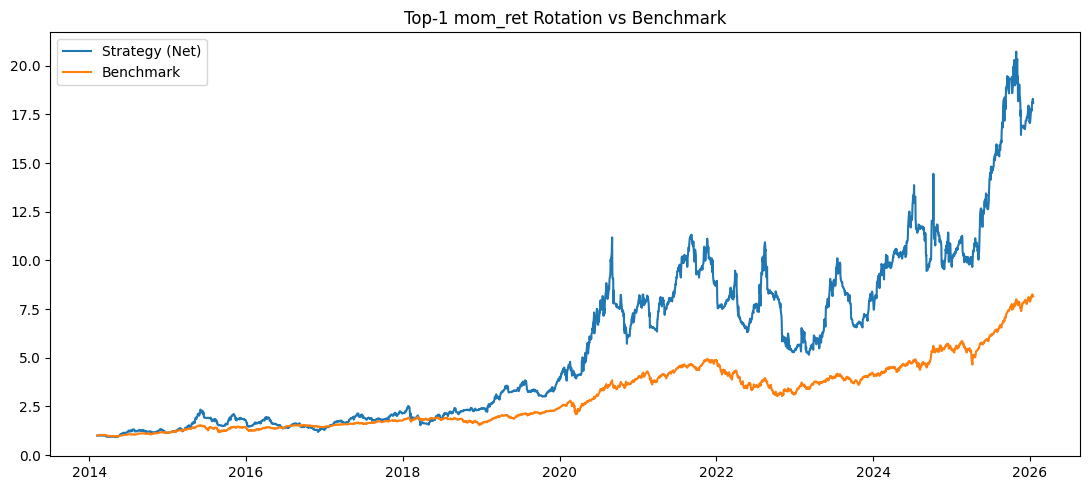

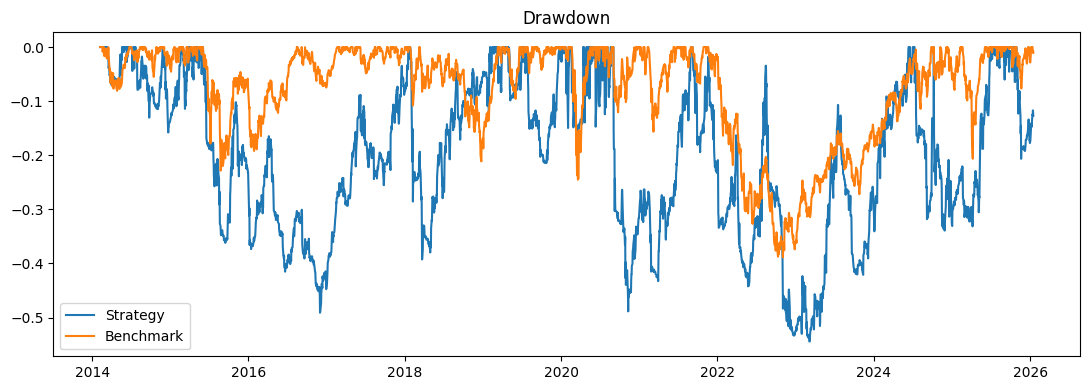

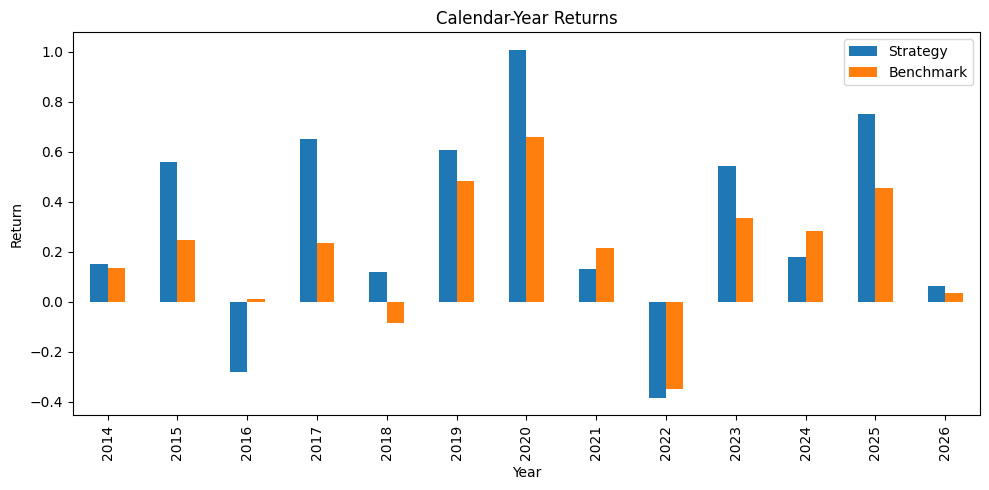

In [66]:
# assets = {
#     'ChiNext': '159915.SZ',
#     'SP500': '513500.SS',
#     'HangSeng': '159920.SZ',
#     'Gold': '518880.SS'
# }
# tickers = list(assets.values())

tickers = [
    "159915.SZ", 
    "^HSI",       # Hang Seng Index
    # "^N225",      # Nikkei 225
    "TQQQ",      
    "GLD",        # Gold ETF proxy
    # "DBB",        # Base metals ETF proxy (有色) on Yahoo
    # "BIL",        # Cash proxy (T-bills ETF)
    # 'IEF',      # 7-10 year treasury bond 
]

market_data = download_market_data(tickers, start=cfg.start, end=cfg.end)


cfg2 = ExperimentConfig(
    start="2014-02-07",
    rebalance_mode='calendar',
    rebalance="W-FRI",
    top_k=1,
    fee_bps=2.0,
    benchmark_mode="equal_weight_all",
    # benchmark_ticker='QQQ',
    signal_name="mom_ret",
    # signal_params = {"lookback": 21, '': 0, "sign": 1},
)


out2 = run_one(market_data, cfg2)
print(out2["stats"])
print(yearly_returns(out2['strat'].net_ret))

plot_compare(
    eq_s=out2["strat"].equity_net,
    eq_b=out2["bench"].equity_net,
    ret_s=out2["strat"].net_ret,
    ret_b=out2["bench"].net_ret,
    title=f"Top-{cfg2.top_k} {cfg2.signal_name} Rotation vs Benchmark",
)

In [59]:
tmp = yf.download('^NDX', start=cfg.start, end=cfg.end)['Close']
tmp['TQQQ'] = market_data.close['TQQQ']

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_97677/1483207773.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tmp = yf.download('^NDX', start=cfg.start, end=cfg.end)['Close']
[*********************100%***********************]  1 of 1 completed


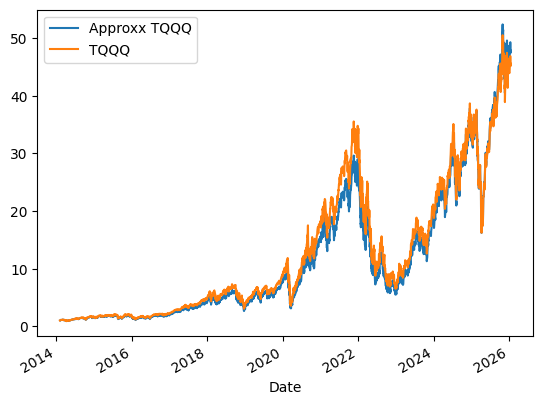

In [63]:
# Approx daily drag: (RiskFreeRate * 2 + ExpenseRatio) / 252
daily_drag = (0.01 * 2 + 0.0086) / 252  
(1 + tmp.pct_change()['^NDX'] * 3 - daily_drag).cumprod().fillna(1).plot(label='Approxx TQQQ')
(1 + tmp.pct_change()['TQQQ']).cumprod().fillna(1).plot(label='TQQQ')
plt.legend()